In [11]:
import numpy as np
import struct
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import time

In [12]:
''' Helper class '''


class MNIST_GAN():
    def __init__(self, directory=""):
        self._directory = directory

        self._data = self._load_binaries("train-images-idx3-ubyte")
        self._data = np.append(self._data, self._load_binaries("t10k-images-idx3-ubyte"), axis=0)
        self._data = ((self._data / 255) * 2) - 1
        self._data = self._data.reshape([-1, 28, 28, 1])

    def _load_binaries(self, file_name):
        path = os.path.join(self._directory, file_name)

        with open(path, 'rb') as fd:
            check, items_n = struct.unpack(">ii", fd.read(8))

            if "images" in file_name and check == 2051:
                height, width = struct.unpack(">II", fd.read(8))
                images = np.fromfile(fd, dtype='uint8')
                return np.reshape(images, (items_n, height, width))
            else:
                raise ValueError("Not a MNIST file: " + path)

    def get_batch(self, batch_size):
        samples_n = self._data.shape[0]
        if batch_size <= 0:
            batch_size = samples_n

        random_indices = np.random.choice(samples_n, samples_n, replace=False)
        data = self._data[random_indices]

        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off]


mnist_data = MNIST_GAN()

(28, 28)


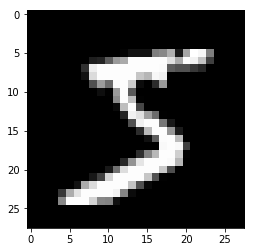

In [13]:
''' Investigate Data '''


pixels = (mnist_data._data[0])
pixels = np.squeeze(pixels)
print(pixels.shape)
plt.imshow(pixels, cmap='gray')
plt.show()

In [14]:
''' Layer functions '''


def feed_forward_layer(x, target_size, normalize=False, activation_function=None):
    print("Forward-Layer:" + str(x.shape))

    fan_in = int(x.shape[-1])

    if activation_function == tf.nn.relu:
        var_init = tf.random_normal_initializer(stddev=2 / fan_in)
    else:
        var_init = tf.random_normal_initializer(stddev=fan_in ** (-1 / 2))
    weights = tf.get_variable("weights", [x.shape[1], target_size], tf.float32, var_init)

    var_init = tf.constant_initializer(0.0)
    biases = tf.get_variable("biases", [target_size], tf.float32, var_init)

    activation = tf.matmul(x, weights) + biases

    if normalize:
        activation = batch_norm(activation, [0])

    return activation_function(activation) if callable(activation_function) else activation


def conv_layer(x, kernel_quantity, kernel_size, stride_size, normalize=False, activation_function=False):
    print("Conv-Layer:" + str(x.shape))
    depth = x.shape[-1]
    fan_in = int(x.shape[1] * x.shape[2])

    if activation_function == tf.nn.relu or activation_function == tf.nn.leaky_relu:
        var_init = tf.random_normal_initializer(stddev=2 / fan_in)
    else:
        var_init = tf.random_normal_initializer(stddev=fan_in ** (-1 / 2))
    kernels = tf.get_variable("kernels", [kernel_size, kernel_size, depth, kernel_quantity], tf.float32, var_init)

    var_init = tf.constant_initializer(0.0)
    biases = tf.get_variable("biases", [kernel_quantity], initializer=var_init)

    activation = tf.nn.conv2d(x, kernels, strides=[1, stride_size, stride_size, 1], padding="SAME") + biases

    if normalize:
        activation = batch_norm(activation, [0, 1, 2])

    return activation_function(activation) if callable(activation_function) else activation


def back_conv_layer(x, target_shape, kernel_size, stride_size, normalize=False, activation_function=False):

    print("Back-Conv-Layer:" + str(x.shape))

    depth = x.shape[-1]
    maps = target_shape[3]
    fan_in = int(x.shape[1] * x.shape[2])

    # get the right initializer distribution according to activation function
    if activation_function == tf.nn.relu:
        var_init = tf.random_normal_initializer(stddev=2 / fan_in)
    else:
        var_init = tf.random_normal_initializer(stddev=fan_in ** (-1 / 2))

    # initialize transposed conv weights
    filters = tf.get_variable("filters", [kernel_size[0], kernel_size[1], maps, depth], tf.float32, var_init)

    # initialize trans conv biases
    var_init = tf.constant_initializer(0.0)
    biases = tf.get_variable("biases", [maps], initializer=var_init)

    # calculate trans conv
    activation = tf.nn.conv2d_transpose(x, filters, target_shape, strides=[1, stride_size, stride_size, 1],
                                        padding="SAME") + biases
    # normalize
    if normalize:
        activation = batch_norm(activation, [0, 1, 2])

    return activation_function(activation) if callable(activation_function) else activation





def flatten(x):
    size = int(np.prod(x.shape[1:]))
    return tf.reshape(x, [-1, size])


def _pop_batch_norm(x, pop_mean, pop_var, offset, scale):
    return tf.nn.batch_normalization(x, pop_mean, pop_var, offset, scale, 1e-6)


def _batch_norm(x, pop_mean, pop_var, mean, var, offset, scale):
    decay = 0.99

    dependency_1 = tf.assign(pop_mean, pop_mean * decay + mean * (1 - decay))
    dependency_2 = tf.assign(pop_var, pop_var * decay + var * (1 - decay))

    with tf.control_dependencies([dependency_1, dependency_2]):
        return tf.nn.batch_normalization(x, mean, var, offset, scale, 1e-6)


def batch_norm(x, axes):
    depth = x.shape[-1]
    mean, var = tf.nn.moments(x, axes=axes)

    var_init = tf.constant_initializer(0.0)
    offset = tf.get_variable("offset", [depth], tf.float32, var_init)
    var_init = tf.constant_initializer(1.0)
    scale = tf.get_variable("scale", [depth], tf.float32, var_init)

    pop_mean = tf.get_variable("pop_mean", [depth], initializer=tf.zeros_initializer(), trainable=False)
    pop_var = tf.get_variable("pop_var", [depth], initializer=tf.ones_initializer(), trainable=False)

    return tf.cond(
        is_training,
        lambda: _batch_norm(x, pop_mean, pop_var, mean, var, offset, scale),
        lambda: _pop_batch_norm(x, pop_mean, pop_var, offset, scale)
    )



In [15]:
''' Hyperparameters '''


batch_size = 32
gen_maps_l1 = 64
gen_maps_l2 = 32
gen_maps_l3 = 16
dis_maps_l1 = 8
dis_maps_l2 = 16
dis_maps_l3 = 32
dim_z = (batch_size, 50)
learn_rate = 0.0004
beta1 = 0.5
epochs = 2

In [16]:
''' Generator '''


tf.reset_default_graph()

with tf.variable_scope("generator"):
    
    # Sample the random inputs to create vector z
    z = tf.placeholder(tf.float32, dim_z)

    is_training = tf.placeholder(tf.bool, None)

    with tf.variable_scope("layer-1"):
        l1 = feed_forward_layer(z, gen_maps_l1 * 4 * 4, True, tf.nn.relu)
        l1 = tf.reshape(l1, (batch_size, 4, 4, gen_maps_l1))
        print("layer-1 shape:", l1.shape)

    with tf.variable_scope("layer-2"):
        l2 = back_conv_layer(l1, (batch_size, 7, 7, gen_maps_l2), (5, 5), 2, True, tf.nn.relu)
        print("layer-2 shape:", l2.shape)

    with tf.variable_scope("layer-3"):
        l3 = back_conv_layer(l2, (batch_size, 14, 14, gen_maps_l3), (5, 5), 2, True, tf.nn.relu)
        print("layer-3 shape:", l3.shape)

    with tf.variable_scope("layer-4"):
        l4 = back_conv_layer(l3, (batch_size, 28, 28, 1), (5, 5), 2, False, tf.nn.tanh)
        print("layer-4 shape:", l4.shape)

Forward-Layer:(32, 50)
layer-1 shape: (32, 4, 4, 64)
Back-Conv-Layer:(32, 4, 4, 64)
layer-2 shape: (32, 7, 7, 32)
Back-Conv-Layer:(32, 7, 7, 32)
layer-3 shape: (32, 14, 14, 16)
Back-Conv-Layer:(32, 14, 14, 16)
layer-4 shape: (32, 28, 28, 1)


In [17]:
''' Discriminator '''


# concatenate original images
real_images = tf.placeholder(tf.float32, [batch_size, 28, 28, 1])
concat = tf.concat((l4, real_images), 0)

with tf.variable_scope("discriminator"):
    with tf.variable_scope("layer-5"):
        l5 = conv_layer(concat, dis_maps_l1, 5, 2, False, tf.nn.leaky_relu)
        print("layer-5 shape:", l5.shape)

    with tf.variable_scope("layer-6"):
        l6 = conv_layer(l5, dis_maps_l2, 5, 2, False, tf.nn.leaky_relu)
        print("layer-6 shape:", l6.shape)

    with tf.variable_scope("layer-7"):
        l7 = conv_layer(l6, dis_maps_l3, 5, 2, False, tf.nn.leaky_relu)
        l7 = tf.reshape(l7, (batch_size * 2, 4 * 4 * 32))
        print("layer-7 shape:", l7.shape)

    with tf.variable_scope("layer-8"):
        l8 = feed_forward_layer(l7, 1, False, tf.nn.sigmoid)
        print("layer-8 shape:", l8.shape)

        
# generate labels

dis_labels = tf.concat((tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))), 0)
print("dis_labels shape:", dis_labels.shape)

gen_labels = tf.ones((batch_size, 1))
print("gen_labels shape:", gen_labels.shape)


# separate parameters

trainable_variables = tf.trainable_variables()
# Get weights of the generator and the distinguisher independently
dis_variables = [var for var in trainable_variables if "discriminator" in var.name]
gen_variables = [var for var in trainable_variables if "generator" in var.name]


# ... define respective losses and two different optimizers ...

dis_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=dis_labels, logits=l8)
dis_cross_entropy = tf.reduce_mean(dis_cross_entropy)
dis_optimizer = tf.train.AdamOptimizer(learn_rate, beta1)
dis_training_step = dis_optimizer.minimize(dis_cross_entropy, var_list=dis_variables)
tf.summary.scalar("dis_loss", dis_cross_entropy)

gen_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=gen_labels, logits=l8[:batch_size])
gen_cross_entropy = tf.reduce_mean(gen_cross_entropy)
gen_optimizer = tf.train.AdamOptimizer(learn_rate, beta1)
gen_training_step = gen_optimizer.minimize(gen_cross_entropy, var_list=gen_variables)
tf.summary.scalar("gen_loss", gen_cross_entropy)

merged_summaries = tf.summary.merge_all()

Conv-Layer:(64, 28, 28, 1)
layer-5 shape: (64, 14, 14, 8)
Conv-Layer:(64, 14, 14, 8)
layer-6 shape: (64, 7, 7, 16)
Conv-Layer:(64, 7, 7, 16)
layer-7 shape: (64, 512)
Forward-Layer:(64, 512)
layer-8 shape: (64, 1)
dis_labels shape: (64, 1)
gen_labels shape: (32, 1)


initialized
Epoch: 1 Step: 1 Dis_Loss: 0.72406805 Gen_Loss: 0.47405607 Speed: -1.348073959350586


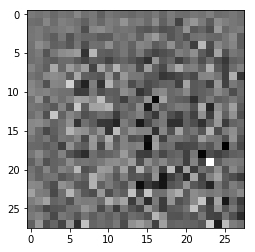

Epoch: 1 Step: 500 Dis_Loss: 0.6932719 Gen_Loss: 0.69285357 Speed: -40.33379888534546


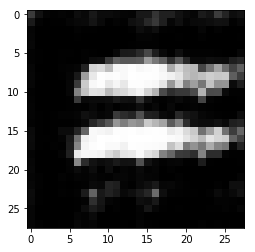

Epoch: 1 Step: 1000 Dis_Loss: 0.6934787 Gen_Loss: 0.69248605 Speed: -38.59887480735779


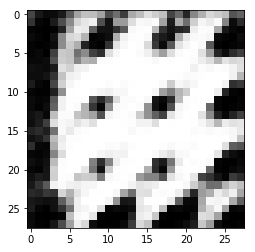

Epoch: 1 Step: 1500 Dis_Loss: 0.69318503 Gen_Loss: 0.69307107 Speed: -46.5216281414032


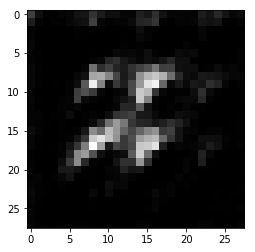

Epoch: 1 Step: 2000 Dis_Loss: 0.69316673 Gen_Loss: 0.6931075 Speed: -39.21267485618591


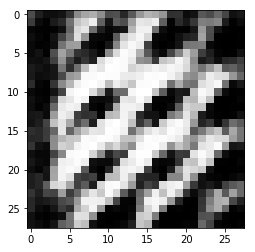

Epoch: 2 Step: 2500 Dis_Loss: 0.6931577 Gen_Loss: 0.69312584 Speed: -42.35160684585571


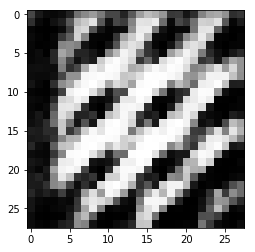

Epoch: 2 Step: 3000 Dis_Loss: 0.6931536 Gen_Loss: 0.69313407 Speed: -46.87728691101074


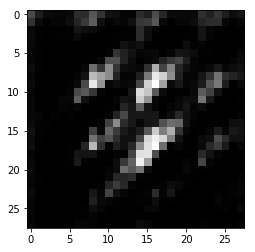

Epoch: 2 Step: 3500 Dis_Loss: 0.6931519 Gen_Loss: 0.6931374 Speed: -48.3798611164093


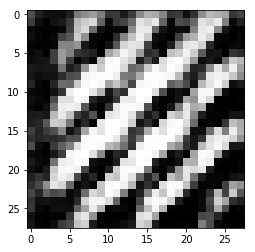

Epoch: 2 Step: 4000 Dis_Loss: 0.6931507 Gen_Loss: 0.6931399 Speed: -46.87469792366028


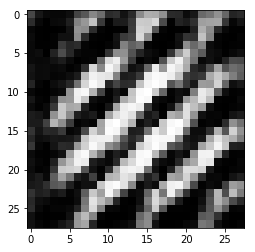

finished


In [22]:
''' Training '''


train_writer = tf.summary.FileWriter("./summaries/train", tf.get_default_graph())

# accumulated losses for plotting
acc_dis_loss = []
acc_gen_loss = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    print("initialized")

    # track time
    start = time.time()

    # training step for plotting
    step = 1

    for epoch in range(1, epochs+1):

        for batch in mnist_data.get_batch(batch_size):

            # initialize input vector
            z_init = np.random.uniform(size=dim_z, low=-1, high=1)

            # values we want to retrieve
            goal = [merged_summaries, dis_cross_entropy, gen_cross_entropy, dis_training_step, gen_training_step]

            # values we feed in the graph
            feed_dict = {z: z_init,
                         real_images: batch,
                         is_training: True
                         }

            # training steps
            summaries, dis_loss, gen_loss, _, _ = sess.run(
                goal,
                feed_dict
            )
            
            
            # append for plotting
            acc_dis_loss.append(dis_loss)
            acc_gen_loss.append(gen_loss)
            
            train_writer.add_summary(summaries, step)

            # status text
            if step % 500 == 0 or step == 1:
                print("Epoch:", epoch,
                      "Step:", step,
                      "Dis_Loss:", dis_loss,
                      "Gen_Loss:", gen_loss,
                      "Speed:", start-time.time()
                      )
                
                # show a example image
                image = sess.run(l4, feed_dict = {z: z_init,
                                                    is_training: False
                                                    })
                plt.imshow(np.squeeze(image[0]), cmap='gray')
                plt.show()
                
                # reset time track
                start = time.time()

            step = step + 1


    saver.save(sess, "./weights/", step)
    print("finished")

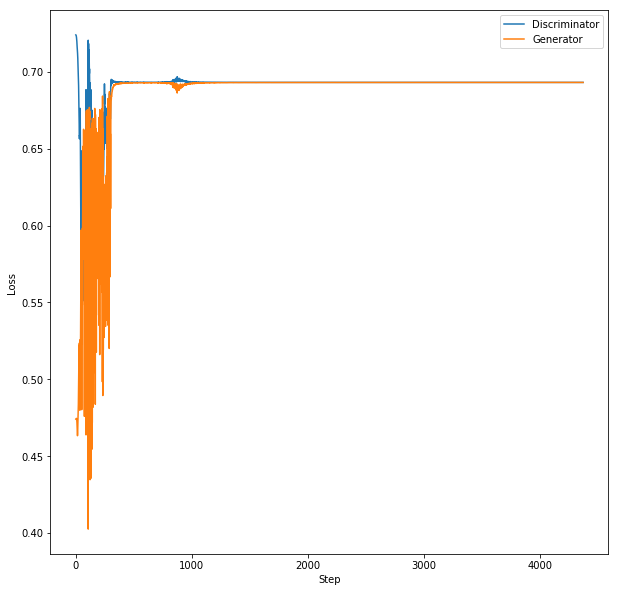

In [23]:
''' Loss plot'''


fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111)
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.plot(acc_dis_loss, label='Discriminator')
ax.plot(acc_gen_loss, label='Generator')
ax.legend()
plt.show()